# Stroke Classfier
> - Gabrile Serafini
> - Marco Sousa-Poza

This Notebook discribes the computations made to find an optimal stroke classifier based on real healthcare data.

## Exploring the Data
In the following the data will be read and prepared for further use.

In [1]:
# All the necessary imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
%matplotlib inline

mpl.rcParams['figure.dpi'] = 100

In [2]:
# Reading the data into a data frame
df_health = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df_health.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


We see that the data contains some NaN values. If there are not too many we can delete them.

In [3]:
print("The number of NaN values for each column is:")
print(df_health.isna().sum())
print("There are {} rows in this df.".format(df_health.shape[0]))

The number of NaN values for each column is:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
There are 5110 rows in this df.


Next we change the nominal attributes to numbers. This is important for the more mathematical models we are going to use later on.

In [4]:
for col in df_health.select_dtypes(include=['object']).columns:
    print(df_health[col].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


## Clean Data

We saw earlier that there are some many `Nan` values in the bmi column. Therefore we will atempt to mean those values based on the gender and the age group.

In [5]:
df_health.drop('id', axis=1, inplace=True)
df_health.drop(df_health[df_health['gender'] == 'Other'].index, inplace=True)

df_mean = df_health.groupby(['gender', pd.cut(df_health['age'], np.arange(0, 100, 10))]).mean()
df_mean.drop(['hypertension', 'age', 'heart_disease', 'stroke', 'avg_glucose_level'], axis=1, inplace=True)
df_mean.reset_index(inplace=True)
df_mean.rename({'bmi':'avg_bmi', 'age':'age_group'}, axis=1, inplace=True)
df_health['age_group'] = pd.cut(df_health['age'], np.arange(0, 100, 10))
df_map = df_health.merge(df_mean, on=('gender', 'age_group'), how='inner')['avg_bmi']
df_health['bmi'].fillna(df_map, inplace=True)
df_health.drop('age_group', axis=1, inplace=True)

print('We now have {} remaining nan values!'.format(df_health['bmi'].isna().sum()))

We now have 0 remaining nan values!


Next we have to look for any outliers:

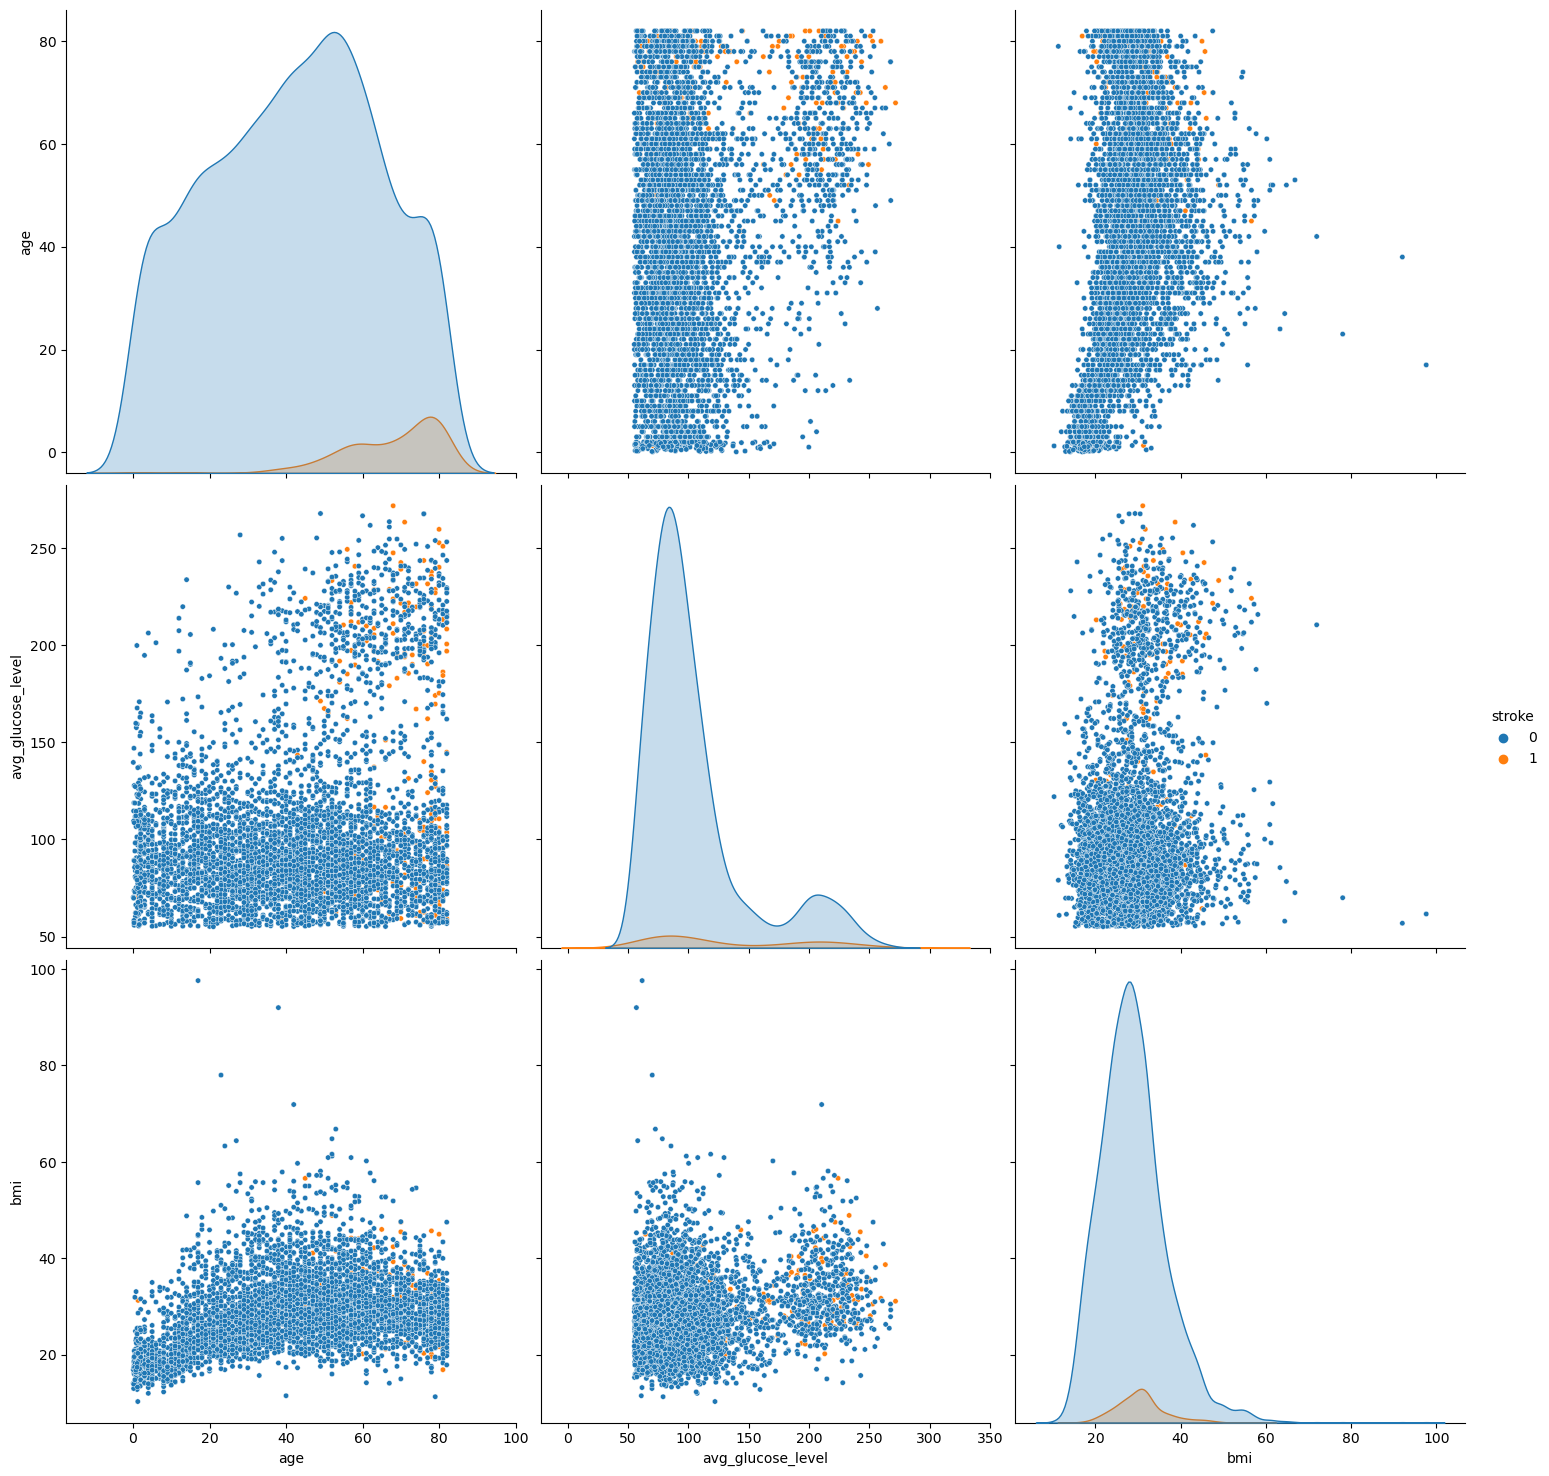

In [6]:
ax = sns.pairplot(df_health['age avg_glucose_level bmi stroke'.split()], hue='stroke', height=5, plot_kws={"s": 15})
plt.show()

There are quite some bmi values that are too high:

In [7]:
df_health = df_health[df_health['bmi'] <= 70]

Next we change the nominal attributes to numerical ones. This is important for the numerical classifiers.

In [8]:
gender_dict = {'Female':1, 'Male':0}
married_dict = {'Yes':1, 'No':0}
worktype_dict = {'Private':4, 'Self-employed':3, 'children':2, 'Govt_job':1, 'Never_worked':0}
residence_dict = {'Urban':1, 'Rural':0}
smoke_dict = {'never smoked':1,'formerly smoked':2,'smokes':3, 'Unknown':4}
health_numerical = df_health.replace({
    'gender' : gender_dict,
    'ever_married' :married_dict,
    'work_type' : worktype_dict,
    'Residence_type' : residence_dict,
    'smoking_status' : smoke_dict
})

In [9]:
health_np = health_numerical.values

Let also standardize the data to get rid of any scalars

In [10]:
y = health_np[:,-1]
columns = list(health_numerical.columns[:-1])
target = health_numerical.columns[-1]
X = health_np[:, :-1]

## Data Vizualisation



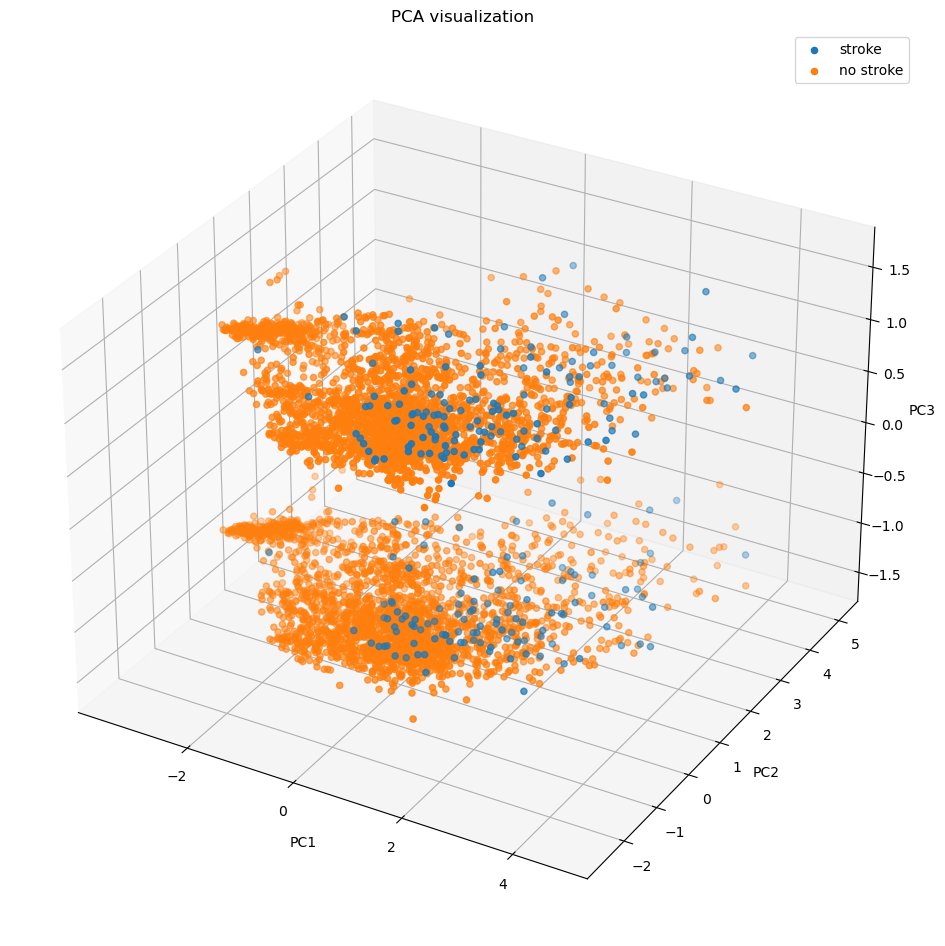

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
stc = StandardScaler()
pca = PCA()
p = make_pipeline(stc, pca)
health_pca = p.fit_transform(X)

# Plot PCA
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(health_pca[y==1][:,0], health_pca[y==1][:,1], health_pca[y==1][:,2], label='stroke')
ax.scatter(health_pca[y==0][:,0], health_pca[y==0][:,1], health_pca[y==0][:,2], label='no stroke')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
ax.set_title('PCA visualization')

plt.show()

We can see that the data is not well separated by the PCs. This is a indicator that the data will probably not be that well separated with a linear model. This is something we need to keep in mind when choosing hyperparameters for some of our classifiers.

#### Correlations
Let us see if there are any correlations

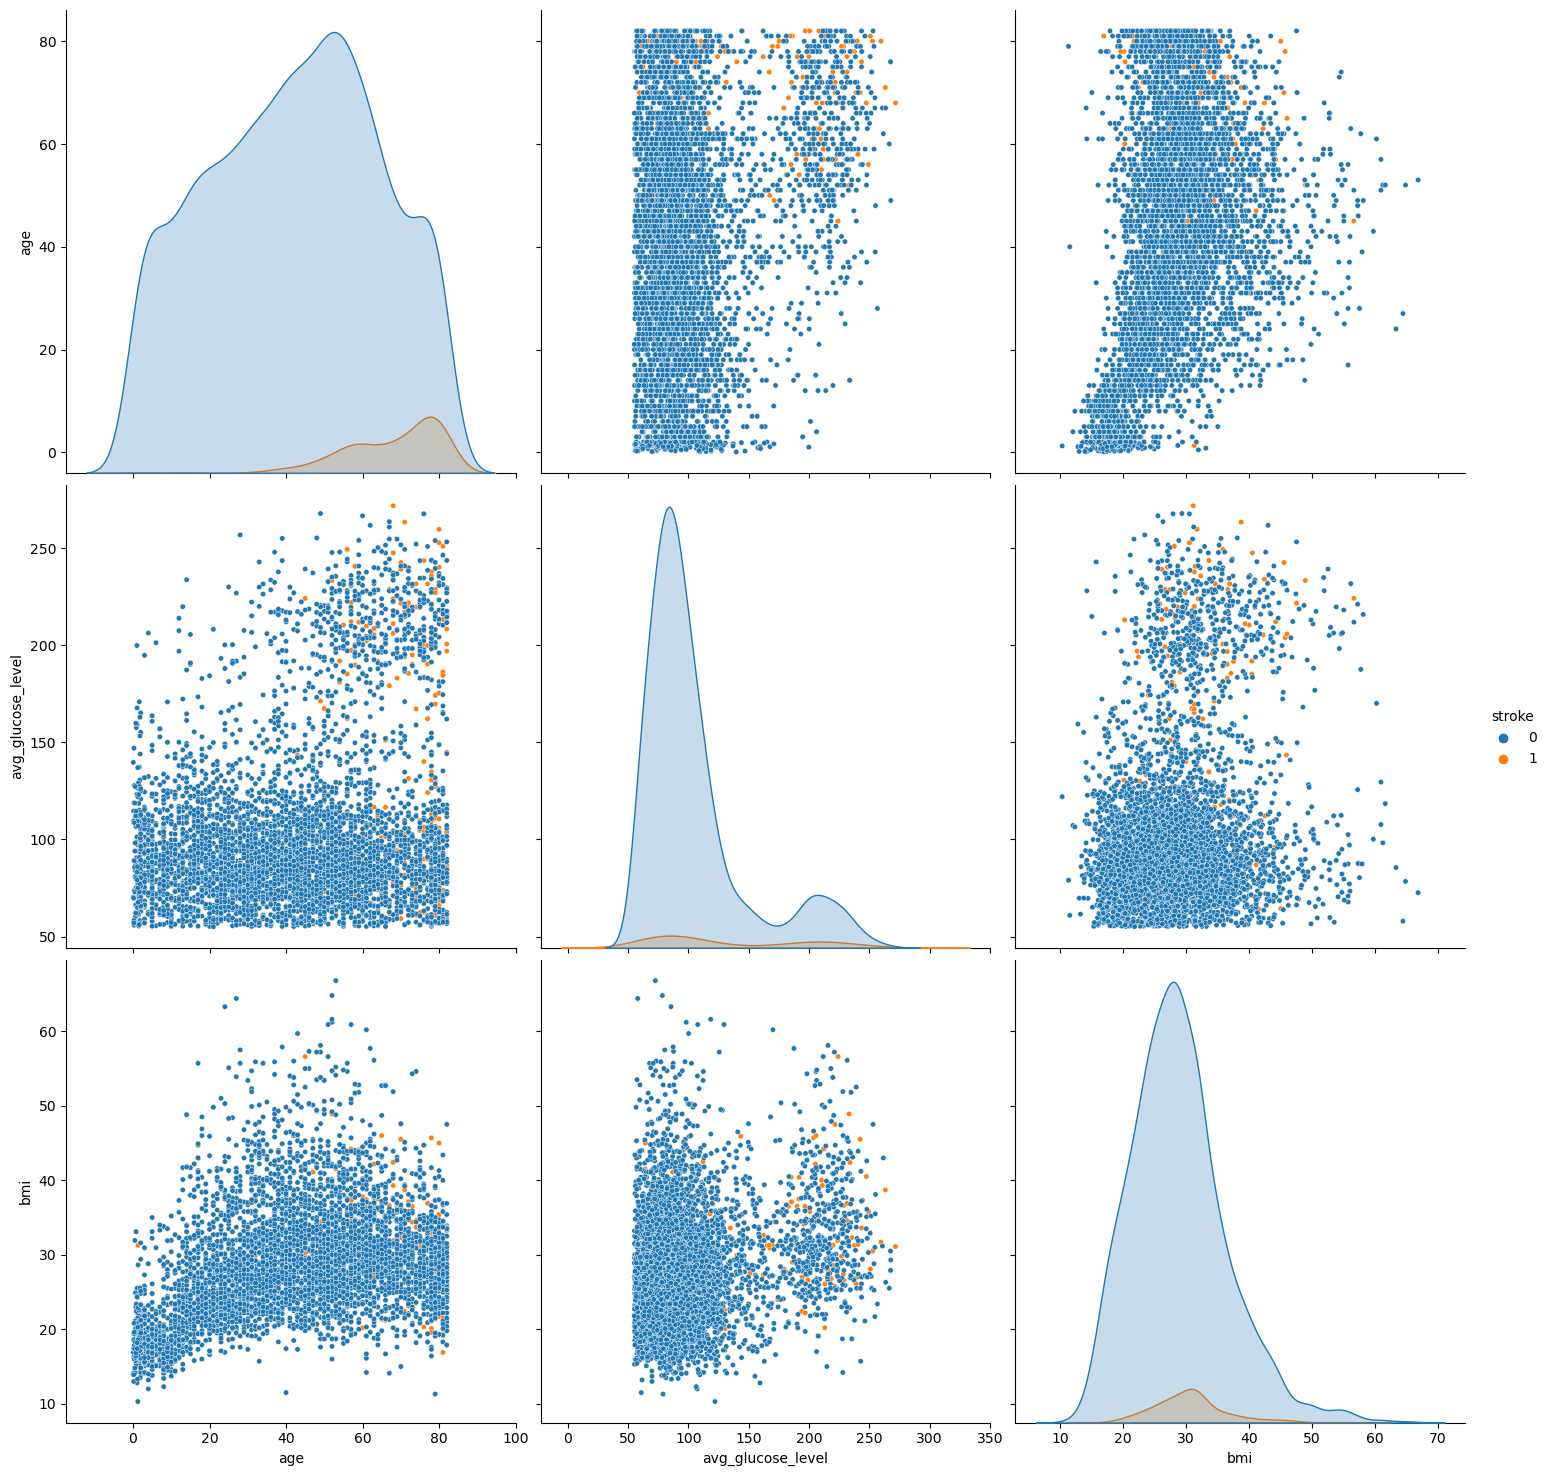

In [12]:
ax = sns.pairplot(df_health['age avg_glucose_level bmi stroke'.split()], hue='stroke', height=5, plot_kws={"s": 15})
plt.show()

## Classification

### Models

In [13]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

### Preprocessing

In [14]:
# normalisation
X = sc.fit_transform(X)

### Tree Classifier

Finding the right hyper-parameters for our tree:

In [34]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from itertools import product

min_splits = [n for n in range(50, 150, 10)]
max_depths = [n for n in range(5,120,15)]

avg_scores = pd.DataFrame(columns='fit_time score_time test_recall test_accuracy test_roc_auc min_splits max_depth'.split())
for min_split, max_depth in product(min_splits, max_depths):
    model = DecisionTreeClassifier(
        criterion='gini', 
        max_depth=max_depth, 
        min_samples_split=min_split,
        class_weight='balanced'
    )
    scores = pd.DataFrame(cross_validate(model, X, y, scoring=('recall', 'accuracy', 'roc_auc'), cv=kf, n_jobs=-1)).mean()
    scores['min_splits'], scores['max_depth'] = min_split, max_depth
    avg_scores = avg_scores.append(scores[avg_scores.columns], ignore_index=True)

avg_scores.drop('fit_time score_time'.split(), axis=1, inplace=True)
avg_scores.sort_values(by='test_recall test_accuracy test_roc_auc'.split(), ascending=False).head(10)

,test_recall,test_accuracy,test_roc_auc,min_splits,max_depth
40,0.747567,0.726823,0.787608,100.0,5.0
48,0.746767,0.724042,0.787055,110.0,5.0
32,0.746733,0.727843,0.787316,90.0,5.0
56,0.745967,0.723846,0.787191,120.0,5.0
72,0.745967,0.722514,0.787279,140.0,5.0
64,0.745167,0.723963,0.787217,130.0,5.0
24,0.743500,0.727569,0.783955,80.0,5.0
16,0.743500,0.727295,0.784246,70.0,5.0
0,0.741867,0.730312,0.782655,50.0,5.0
8,0.741067,0.729216,0.783905,60.0,5.0


We will now take the best performing forrest:

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

clf = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=100, random_state=42)

To see how well the model performed the confuxion matrix of the best performing tree is shown:

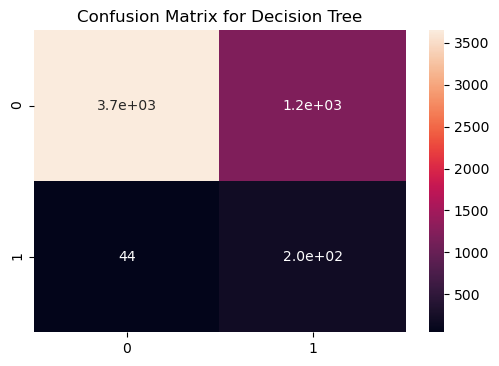

In [36]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, clf.predict(X))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix for Decision Tree')
plt.show()

Since the tree it not that large, we can also vizualize it:

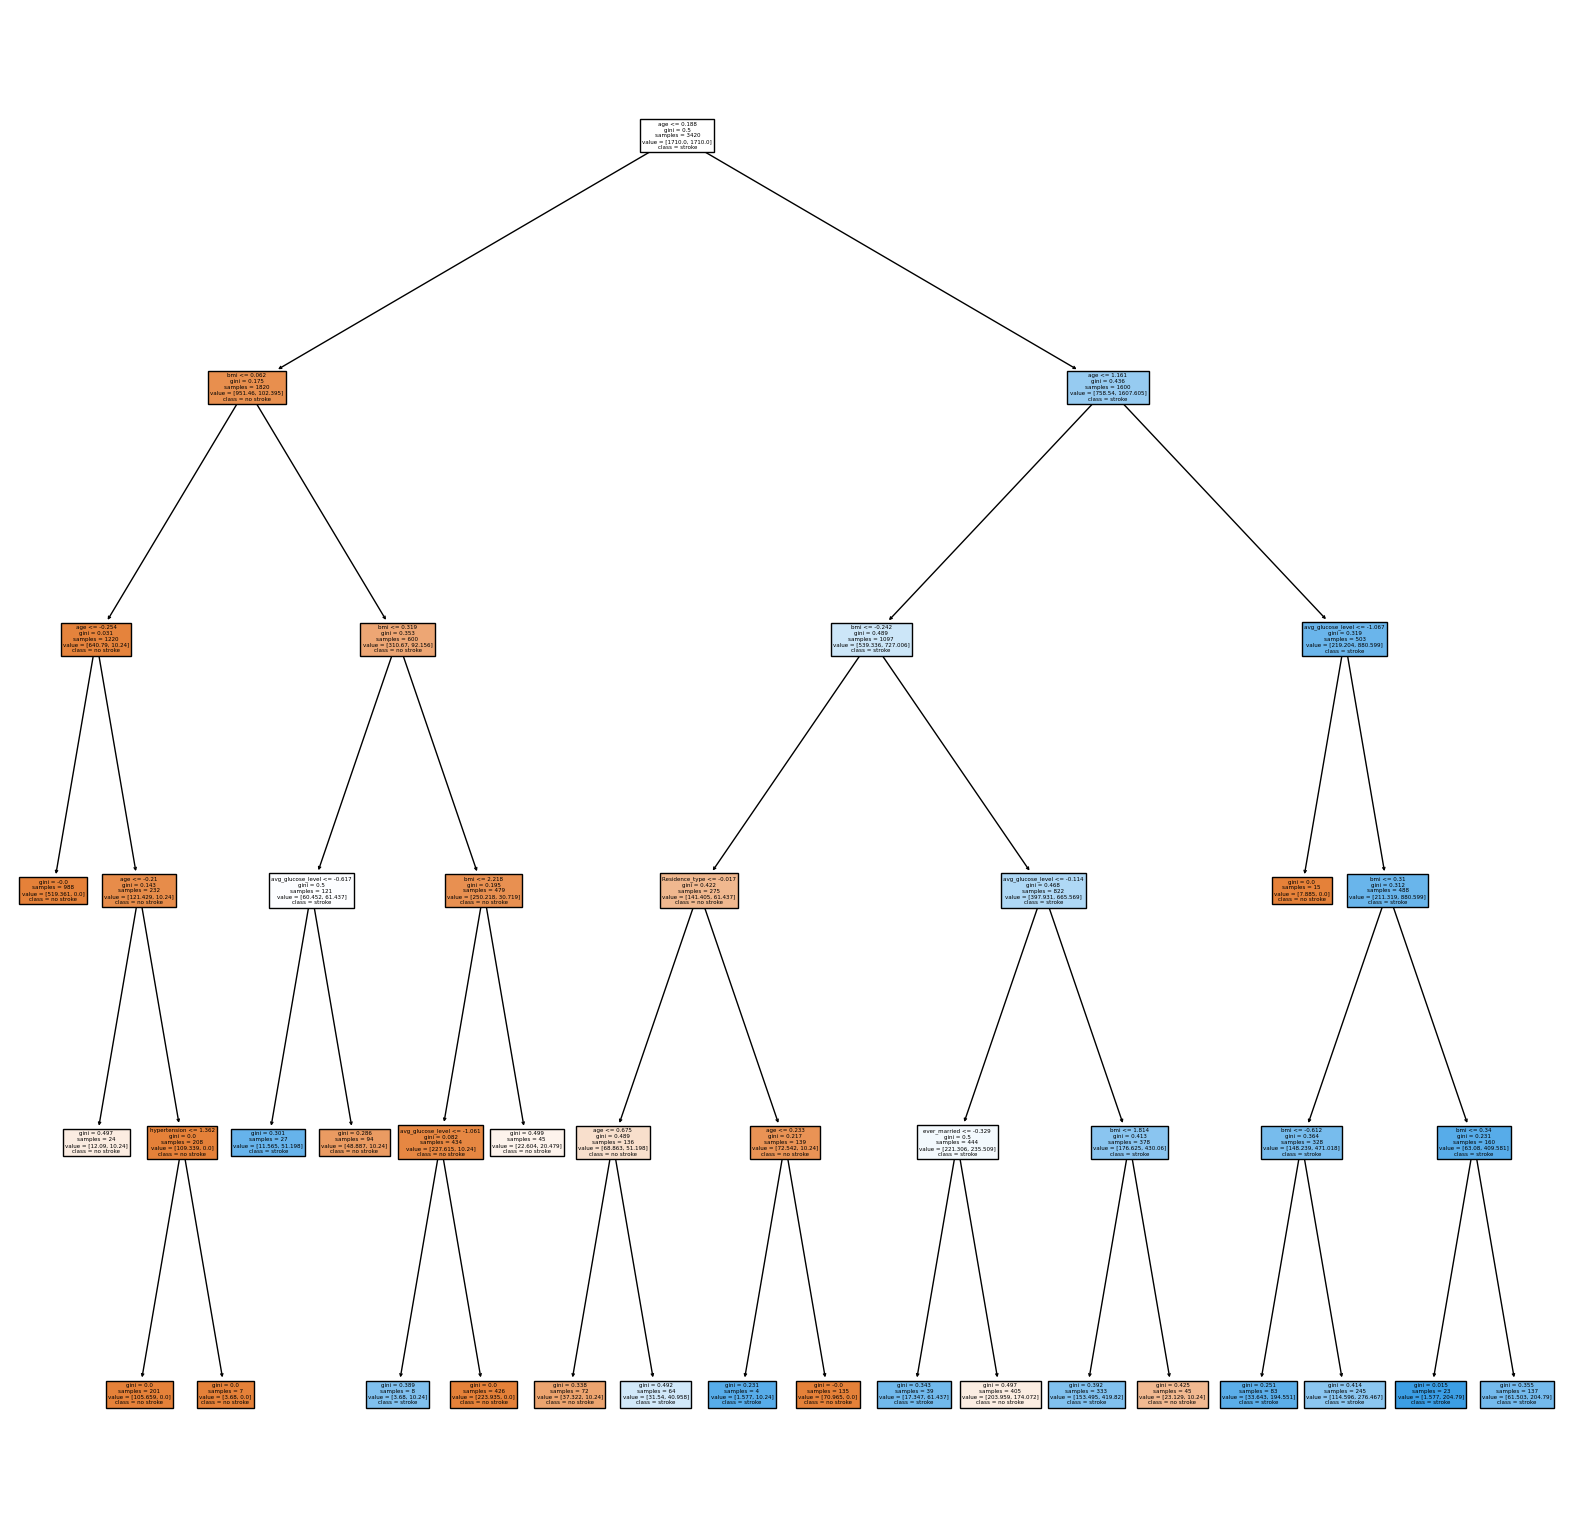

In [37]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(20,20))
ax = plot_tree(clf, 
             feature_names=columns,  
             class_names=['no stroke', 'stroke'],
             max_depth=10,
             filled=True)
plt.show()

fit_time         0.005729
score_time       0.003770
test_recall      0.388500
test_accuracy    0.864214
dtype: float64


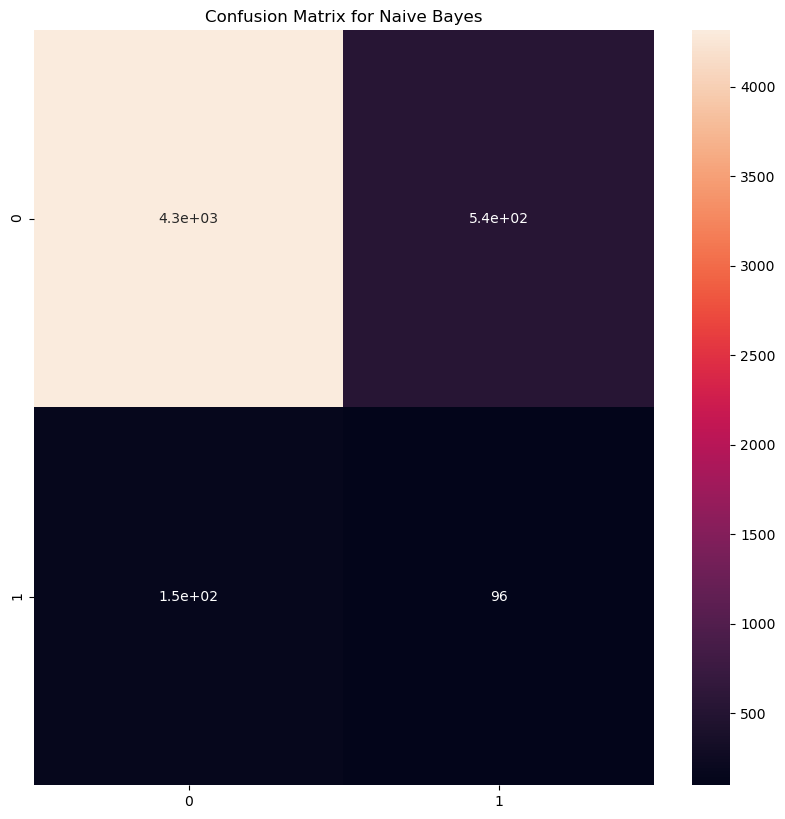

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import seaborn as sns
from itertools import product

model = GaussianNB()
scores = pd.DataFrame(cross_validate(model, X, y, scoring='recall accuracy'.split(), cv=kf, n_jobs=-1, return_estimator=True))
print(scores.mean())


# make a test with confusion matrix
model.fit(X, y)
cm = confusion_matrix(y, model.predict(X))
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

### Support Vector Machine

In [38]:
from sklearn.svm import SVC

kernels = ['poly', 'rbf', 'sigmoid']
degrees = [x for x in range(1, 4, 1)] #increase domain if you want to verify that indeed sigmoid is the best
hypers = [(x, y) for x in kernels for y in degrees if x == 'poly' or y == degrees[0]]

avg_scores = pd.DataFrame(columns='fit_time score_time test_recall test_accuracy test_roc_auc kernel degree'.split())
for kernel, degree in hypers:
    model = SVC(kernel=kernel, degree=degree, class_weight='balanced')
    scores = pd.DataFrame(cross_validate(model, X, y, scoring='recall accuracy roc_auc'.split(), cv=kf, n_jobs=-1)).mean()
    scores['kernel'], scores['degree'] = kernel, degree
    avg_scores = avg_scores.append(scores[avg_scores.columns], ignore_index=True)
avg_scores.drop('fit_time score_time'.split(), axis=1, inplace=True)
avg_scores.sort_values(by='test_recall test_accuracy test_roc_auc'.split(), ascending=False).head(10)

,test_recall,test_accuracy,test_roc_auc,kernel,degree
0,0.831033,0.721686,0.840269,poly,1
1,0.723300,0.763215,0.800380,poly,2
4,0.701033,0.677296,0.717397,sigmoid,1
3,0.659167,0.757025,0.794789,rbf,1
2,0.609533,0.779553,0.765387,poly,3


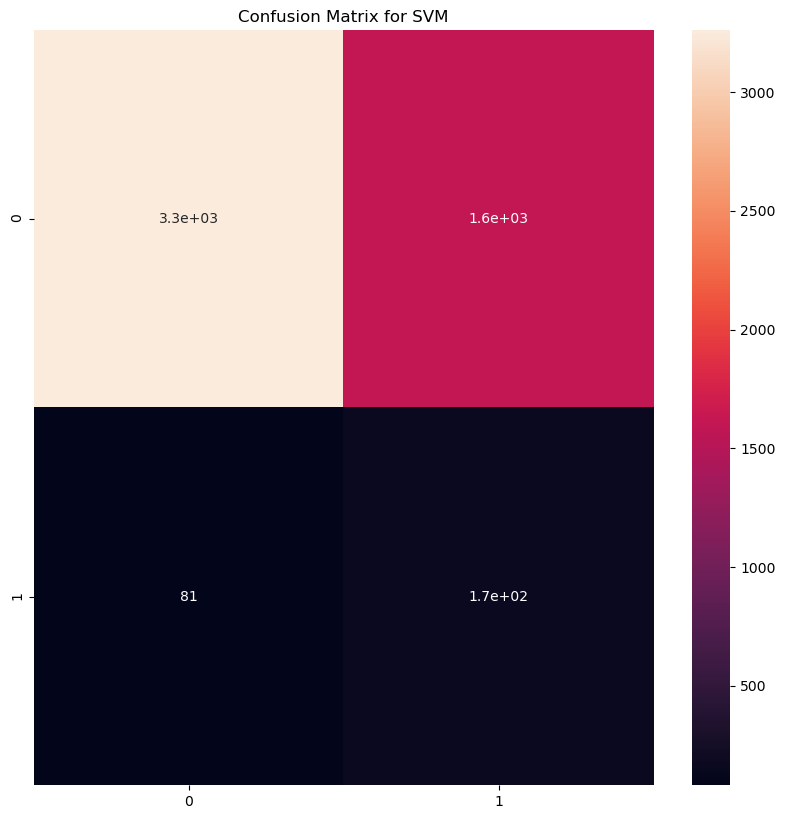

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

svm = SVC(kernel='sigmoid', class_weight='balanced')
svm.fit(X_train, y_train)
cm = confusion_matrix(y, svm.predict(X))
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix for SVM')
plt.show()

### Logistig Regression

In [29]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')
scores = pd.DataFrame(cross_validate(model, X, y, scoring='recall accuracy roc_auc'.split(), cv=kf, n_jobs=-1)).mean()
scores

fit_time         0.035946
score_time       0.010320
test_recall      0.806167
test_accuracy    0.734379
test_roc_auc     0.839790
dtype: float64

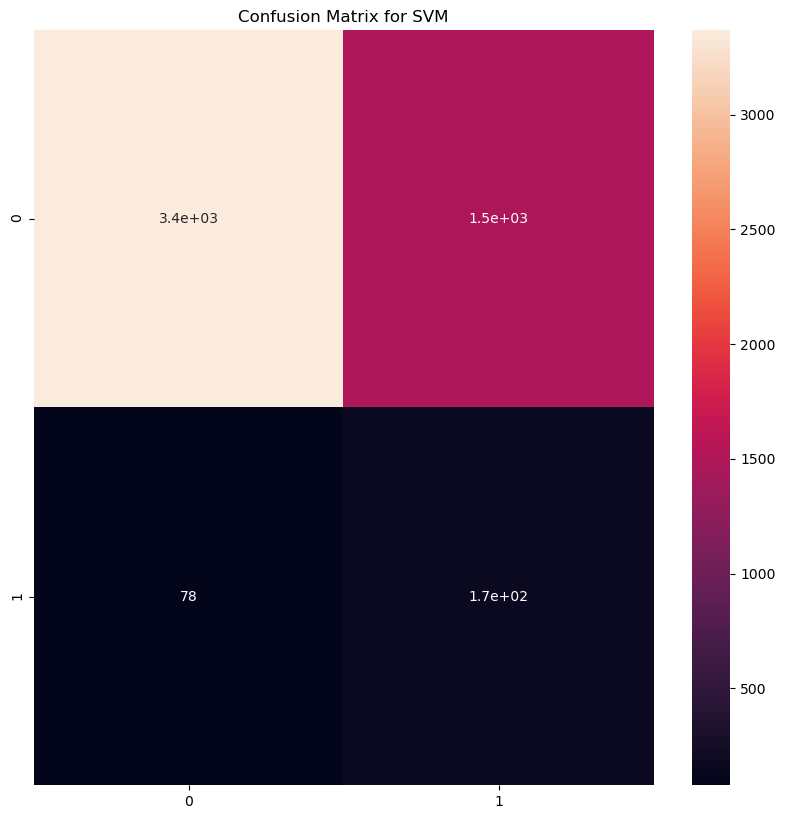

In [31]:
lr = SVC(kernel='sigmoid', class_weight='balanced')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
lr.fit(X_train, y_train)
cm = confusion_matrix(y, lr.predict(X))
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix for SVM')
plt.show()